In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.PINNnet import PINN
from utils.plot_func import plot_field, model_pred_green, plot_error, model_pred
from utils.functions import green
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

strentch = 5
src = [-0.4, 0.4]
k = 2 * np.pi * 20 / 1500 * 100

N = 100

In [3]:
import joblib
state_dict = joblib.load('model_water.joblib')
water = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
water.load_state_dict(state_dict)
state_dict = joblib.load('model_seabed.joblib')
bed = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
bed.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
class CombinedModel(nn.Module):
    def __init__(self, water_net, seabed_net):
        super(CombinedModel, self).__init__()
        self.water_net = water_net
        self.seabed_net = seabed_net

    def forward(self, xz):
        x = xz[:, 0:1]
        z = xz[:, 1:2]

        # 判定条件: z > 0
        mask_water = (z >= 0).float()  # 1表示水层
        mask_seabed = (z < 0).float()  # 1表示海底

        out_water = self.water_net(xz) + green(x, z, src, k=k, strentch=strentch).to('cpu')
        out_seabed = self.seabed_net(xz)

        # 根据mask组合输出
        out = mask_water * out_water + mask_seabed * out_seabed
        return out

In [5]:
model = CombinedModel(water, bed)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


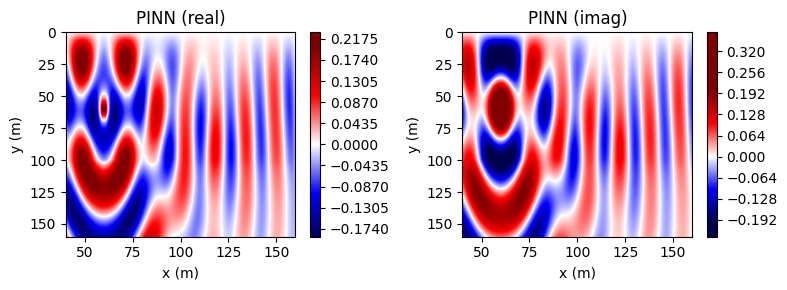

In [6]:
model_pred(model, 1, 1, 0.4, guide_mode='pekeris', is_inverse=False)

In [7]:
Sw = -1
D = 100
z_end = 160
c1 = 1500
rho1 = 1000
c2 = 1700
rho2 = 2000
Zs = 60
f = 20

w = 2 * np.pi * f
k1, k2 = w / c1, w / c2
x_min, x_max = -100, 500

In [8]:
def complex_sqrt(x):
    if x < 0:
        x_sqrt = 1j * np.sqrt(-x)
    else:
        x_sqrt = np.sqrt(x)
    return x_sqrt

In [9]:
def psi_k(k, z, k1=k1, k2=k2, rho1=rho1, rho2=rho2, D=D, Zs=Zs):
    kz_1 = complex_sqrt(k1 ** 2 - k ** 2)
    kz_2 = complex_sqrt(k2 ** 2 - k ** 2)
    A1 = 1j * Sw / (4 * np.pi * kz_1) * (rho2 * kz_1 * np.cos(kz_1 * (D - Zs)) - 1j * rho1 * kz_2 * np.sin(kz_1 * (D - Zs))) / (rho2 * kz_1 * np.cos(kz_1 * D) - 1j * rho1 * kz_2 * np.sin(kz_1 * D))
    A2 = -Sw / (4 * np.pi * kz_1) * (rho2 * kz_1 - rho1 * kz_2) * np.sin(kz_1 * Zs) / (rho2 * kz_1 * np.cos(kz_1 * D) - 1j * rho1 * kz_2 * np.sin(kz_1 * D))
    B = -Sw / (2 * np.pi) * rho1 * np.sin(kz_1 * Zs) / (rho2 * kz_1 * np.cos(kz_1 * D) - 1j * rho1 * kz_2 * np.sin(kz_1 * D))
    if z < Zs:
        psi = Sw * np.exp(1j * kz_1 * (Zs - z)) / (4 * np.pi * 1j * kz_1) + A1 * np.exp(1j * kz_1 * z) + A2 * np.exp(-1j * kz_1 * (z - D))
    elif z >= D:
        psi = B * np.exp(1j * kz_2 * (z - D))
    else:
        psi = Sw * np.exp(1j * kz_1 * (z - Zs)) / (4 * np.pi * 1j * kz_1) + A1 * np.exp(1j * kz_1 * z) + A2 * np.exp(-1j * kz_1 * (z - D))
    return psi

In [10]:
s = np.linspace(-2*k1, 2*k1, 500)
ds = s[1] - s[0]
s_eption = 3 * ds / (2 * np.pi * np.log10(np.e))
s_sigma = 1 / (6 * ds)
kx_s = s - 1j * s_eption * np.tanh(s_sigma * s)

x = np.linspace(x_min, x_max, 100)
z = np.linspace(0, z_end, 100)

psi = np.zeros([len(x), len(z)]) + 0j

for i in tqdm(range(len(x))):
    for j in range(len(z)):
        for m in range(len(kx_s)):
            psi[j, i] += psi_k(kx_s[m], z[j]) * np.exp(1j * kx_s[m] * x[i]) * ds * (1-1j*s_eption*s_sigma / np.cosh(s_sigma*s[m]))

100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


In [11]:
p_ref_real, p_ref_imag = np.zeros_like(psi), np.zeros_like(psi)
for j in range(len(z)):
    if z[j] < D:
        p_ref_real[N - 1 - j, :] = psi[j, :].real
        p_ref_imag[N - 1 - j, :] = psi[j, :].imag
    else:
        p_ref_real[N - 1 - j, :] = rho2 / rho1 * psi[j, :].real
        p_ref_imag[N - 1 - j, :] = rho2 / rho1 * psi[j, :].imag
p_ref = p_ref_real + 1j * p_ref_imag

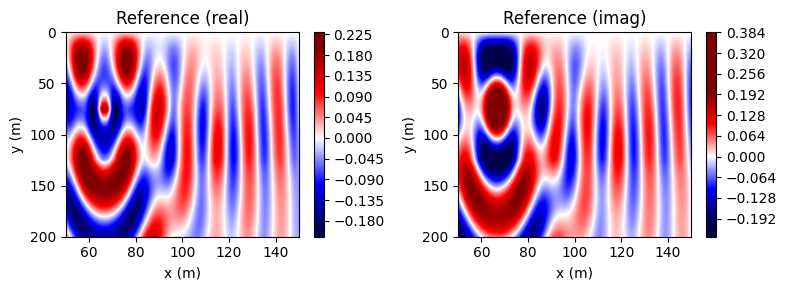

In [12]:
plot_field(p_ref, [50, 150], [-200, 0], bar_max=0.2, title='Reference', filename='Reference')

In [13]:
x, y = np.linspace(-0.6, 0.6, N), np.linspace(-0.6, 1, N)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x, y = x.to('cpu'), y.to('cpu')
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0:1].detach().numpy()
p_imag = model(inputs)[:, 1:2].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
p = p_real + 1j * p_imag

Error(Real) 0.03429571297064349, Error(Imag) 0.029577162510204418


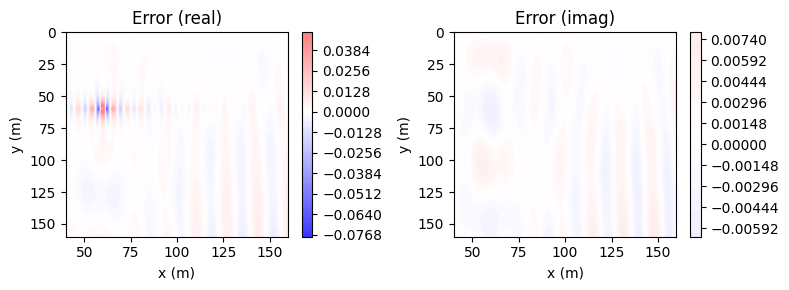

In [14]:
plot_error(p, p_ref, x, y)